# Problem Statement


In this competition provided the visitor's session data, we are challenged  to come up with a regression algorithm to predict the time a buyer will spend on the platform.

Score Data : https://www.machinehack.com/hackathons/buyers_time_prediction_challenge/overview

# Performance Mertic Used

We are  Using the RMSLE


Advantages of using RMSLE
1) Outliers are not impacted much

2) It will give more important when predicted values are less than the original values

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [36]:
pip install catboost

/home/dtr/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/dtr/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 65.7 MB 54 kB/s  eta 0:00:01     |██████████████████████████▋     | 54.7 MB 2.1 MB/s eta 0:00:06     |█████████████████████████████▍  | 60.3 MB 1.3 MB/s eta 0:00:05
     |████████████████████████████████| 13.2 MB 1.6 MB/s eta 0:00:01     |████████████████████████▎       | 10.0 MB 462 kB/s eta 0:00:07
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=d1abdbc82db5c259baaafe868e645c34b0791645a8a71953a1c85ad18e879e6d
  Stored in directory: /home/dtr/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878c

In [2]:
#reading the dataset 
train=pd.read_csv("time_spent/Train.csv")
print('Numbers of rows',train.shape[0])
print('Number of Features',train.shape[1])
print('columns',train.columns.values)
print(train.head(6))


Numbers of rows 5429
Number of Features 9
columns ['session_id' 'session_number' 'client_agent' 'device_details' 'date'
 'purchased' 'added_in_cart' 'checked_out' 'time_spent']
                         session_id  session_number  \
0  57f879e70d3c5fc2a98102d64c9fd84e             715   
1  a5442b0c7c33d0a811e7661e556b2de8              55   
2  305cb1486ed8610c00b37007926cb2c4              11   
3  f2c1ecc9993f0071df91ba178450498c            2794   
4  e460830ae295e55d2216ebdc761ab9a6            3674   
5  b4ae55a4553d43697dcf64b66033677b             550   

                                        client_agent           device_details  \
0  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...         Desktop - Chrome   
1                           Product/8.0 iPhone/8.1.3             iPhone - iOS   
2  Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...       iPhone - MobileWeb   
3  Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...             Desktop - IE   
4  Mozilla/5.0 (iPhone; CPU iPho

# Preparing the data

In [3]:
# Checking for null values
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      5429 non-null   object 
 1   session_number  5429 non-null   int64  
 2   client_agent    5269 non-null   object 
 3   device_details  5429 non-null   object 
 4   date            5429 non-null   object 
 5   purchased       5429 non-null   int64  
 6   added_in_cart   5429 non-null   int64  
 7   checked_out     5429 non-null   int64  
 8   time_spent      5429 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 381.9+ KB


There are null values in the Client_agent column

In [10]:
#printing the rows containing the null values
train[train.isnull().any(axis=1)]

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent


In [3]:
#creating a function to clean the Columns client_agent and device_details
def clean(total_text,index,column,df):
    if type(total_text) is not int:
        total_text = re.sub('[^a-zA-Z\n]', ' ', total_text) # replacing the special char to space
        total_text=re.sub('\s+'," ",total_text)# replacing the multiple spaces with single space
        total_text=re.sub('html'," ",total_text)
        total_text=total_text.lower() #repalcing all char to lower
        df[column][index]=total_text
        
        
        
    

In [4]:
#Cleaning the client_agent column
for i,j in train.iterrows():
    if j["client_agent"] is not  np.nan:
        clean(j["client_agent"],i,"client_agent",train)
train.head(3)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,mozilla windows nt wow applewebkit khtml like ...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,product iphone,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,mozilla iphone cpu iphone os like mac os x app...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704


In [5]:
#Cleaning the  device_details column
for i,j in train.iterrows():
    if j["device_details"] is not  np.nan:
        clean(j["device_details"],i,"device_details",train)
train.head(3)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,product iphone,iphone ios,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,mozilla iphone cpu iphone os like mac os x app...,iphone mobileweb,2019-08-01,0,0,0,21.704


In [51]:
# Doing some analysis to fill null values
train[(train["device_details"]=='other other') & (train["client_agent"].notnull())]["client_agent"].value_counts()

product cfnetwork darwin                                                                   57
typhoeus https github com typhoeus typhoeus                                                26
 unknown                                                                                    6
opera macintosh intel mac os x presto version                                               6
mozilla x linux x applewebkit khtml like gecko chrome safari                                5
product android                                                                             2
mozilla macintosh intel mac os x applewebkit khtml like gecko                               2
safari cfnetwork darwin i macbookpro c                                                      1
mozilla x linux i x applewebkit khtml like gecko chrome safari                              1
mozilla x cros armv l applewebkit khtml like gecko chrome safari                            1
dalvik linux u android lg d build lrx r a                   

As we see "product cfnetwork darwin" is most used "client_agent" for "device_details" "Other Other" so we will replace null values in the "other other" "device_details" with "product cfnetwork darwin"

In [6]:
#replacing the null values in the "device_details"
train['client_agent'].mask((train['device_details'] == 'other other') & (train["client_agent"].isnull()), 'product cfnetwork darwin', inplace=True)

In [56]:
train[(train["session_number"]==506) & (train["device_details"]=="other other")]

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
19,ffd9783163e22452b6b8c36205310ff9,506,product cfnetwork darwin,other other,2019-09-01,0,0,0,21.452


In [7]:
# Doing some analysis to fill null values 
train[(train["device_details"]=='unknown mobileweb') & (train["client_agent"].notnull())]["client_agent"].value_counts()

mozilla linux android bn nookhd build ktu q applewebkit khtml like gecko chrome safari     3
Name: client_agent, dtype: int64

As we see "mozilla linux android bn nookhd build ktu q applewebkit khtml like gecko chrome safari" is most used "client_agent" for "device_details" "unknown mobileweb" so we will replace null values in the "unknown mobileweb" "device_details" with "mozilla linux android bn nookhd build ktu q applewebkit khtml like gecko chrome safari"

In [7]:
#replacing the null values in the "device_details"
train['client_agent'].mask((train['device_details'] == 'unknown mobileweb') & (train["client_agent"].isnull()), 'mozilla linux android bn nookhd build ktu q applewebkit khtml like gecko chrome safari', inplace=True)

In [9]:
train[(train["session_number"]==693) & (train["device_details"]=='unknown mobileweb')]

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
5319,9c5b7ca33cb906de66a9dba709008f94,693,mozilla linux android bn nookhd build ktu q ap...,unknown mobileweb,2019-07-19,0,0,0,18.568


In [8]:
# Creating the Function to Date,Year,Month from date column
def date(data):    
    data["date"] = pd.to_datetime(data.date)
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
date(train)
train.head(10)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,year,month,day
0,57f879e70d3c5fc2a98102d64c9fd84e,715,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-01-22,1,0,0,236.886,2020,1,22
1,a5442b0c7c33d0a811e7661e556b2de8,55,product iphone,iphone ios,2020-02-27,1,0,0,1277.455,2020,2,27
2,305cb1486ed8610c00b37007926cb2c4,11,mozilla iphone cpu iphone os like mac os x app...,iphone mobileweb,2019-08-01,0,0,0,21.704,2019,8,1
3,f2c1ecc9993f0071df91ba178450498c,2794,mozilla compatible msie windows nt wow trident,desktop ie,2019-12-30,0,1,0,455.201,2019,12,30
4,e460830ae295e55d2216ebdc761ab9a6,3674,mozilla iphone cpu iphone os like mac os x app...,iphone web,2019-09-10,0,0,0,1164.877,2019,9,10
5,b4ae55a4553d43697dcf64b66033677b,550,product android device lge lg d carrier yes op...,android phone android,2020-02-06,0,1,0,6010.343,2020,2,6
6,a17491477ea11e951286f583b3095899,198,mozilla windows nt wow rv gecko firefox,desktop firefox,2019-05-30,1,1,1,8471.435,2019,5,30
7,939dfd89beacc36f5f8acd5bfa062b57,2915,mozilla windows nt wow trident touch rv like g...,android tablet web,2020-01-03,0,0,0,83.030,2020,1,3
8,1334aaff26b65ec26dc1e539c0ed20cb,319,product iphone,iphone ios,2019-10-19,0,0,0,97.722,2019,10,19
9,750d0bfd2fb9ba1628586bb98c1611ca,2574,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-03-04,0,1,0,44.841,2020,3,4


# Univariate analysis

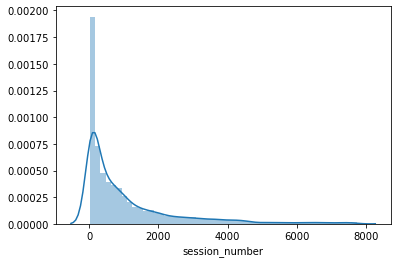

In [14]:
#session number
sns.distplot(train['session_number'], hist=True, kde=True)

Right skewed data

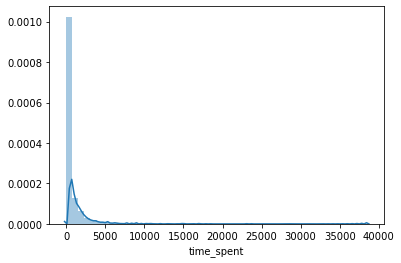

In [19]:
#time_spent
sns.distplot(train['time_spent'], hist=True, kde=True)

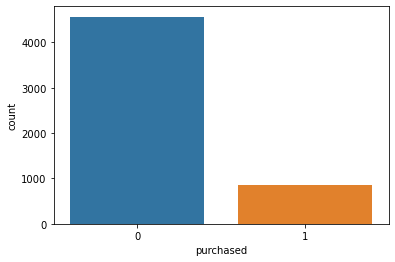

In [15]:
#purchased
sns.countplot(train["purchased"])

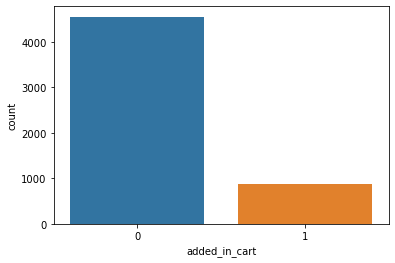

In [16]:
#added_in_cart
sns.countplot(train["added_in_cart"])

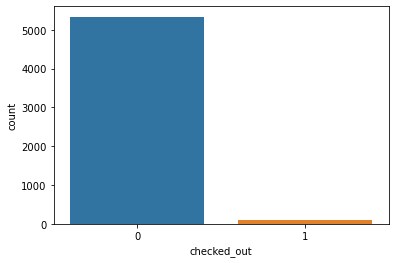

In [17]:
#checked_out
sns.countplot(train["checked_out"])

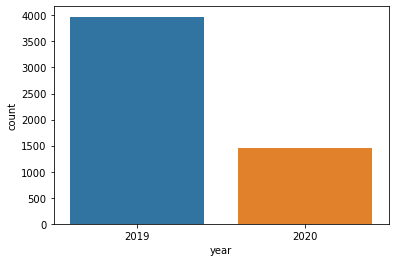

In [18]:
#year
sns.countplot(train["year"])

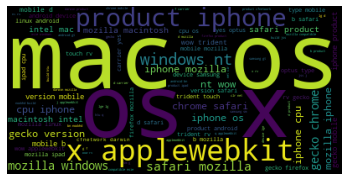

In [27]:
# client_agent
wordcloud2 = WordCloud().generate(' '.join(train['client_agent']))
# Plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [25]:
train.columns.values

array(['session_id', 'session_number', 'client_agent', 'device_details',
       'date', 'purchased', 'added_in_cart', 'checked_out', 'time_spent',
       'year', 'month', 'day'], dtype=object)

In [73]:
train.head(10)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,year,month,day
0,57f879e70d3c5fc2a98102d64c9fd84e,715,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-01-22,1,0,0,236.886,2020,1,22
1,a5442b0c7c33d0a811e7661e556b2de8,55,product iphone,iphone ios,2020-02-27,1,0,0,1277.455,2020,2,27
2,305cb1486ed8610c00b37007926cb2c4,11,mozilla iphone cpu iphone os like mac os x app...,iphone mobileweb,2019-08-01,0,0,0,21.704,2019,8,1
3,f2c1ecc9993f0071df91ba178450498c,2794,mozilla compatible msie windows nt wow trident,desktop ie,2019-12-30,0,1,0,455.201,2019,12,30
4,e460830ae295e55d2216ebdc761ab9a6,3674,mozilla iphone cpu iphone os like mac os x app...,iphone web,2019-09-10,0,0,0,1164.877,2019,9,10
5,b4ae55a4553d43697dcf64b66033677b,550,product android device lge lg d carrier yes op...,android phone android,2020-02-06,0,1,0,6010.343,2020,2,6
6,a17491477ea11e951286f583b3095899,198,mozilla windows nt wow rv gecko firefox,desktop firefox,2019-05-30,1,1,1,8471.435,2019,5,30
7,939dfd89beacc36f5f8acd5bfa062b57,2915,mozilla windows nt wow trident touch rv like g...,android tablet web,2020-01-03,0,0,0,83.030,2020,1,3
8,1334aaff26b65ec26dc1e539c0ed20cb,319,product iphone,iphone ios,2019-10-19,0,0,0,97.722,2019,10,19
9,750d0bfd2fb9ba1628586bb98c1611ca,2574,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-03-04,0,1,0,44.841,2020,3,4


# preprocessing the data 

In [36]:
x_train,x_test,y_train,y_test=train_test_split(train,train["time_spent"],test_size=0.2,random_state=1)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1)
print("shape of x_train",x_train.shape)
print("shape of x_cv",x_cv.shape)
print("shape of x_test",x_test.shape)


shape of x_train (3474, 12)
shape of x_cv (869, 12)
shape of x_test (1086, 12)


# linear regression 

In [90]:
#label encoder of device details
label=LabelEncoder()
label.fit(train["device_details"].values.reshape(-1,1))
device_details_label=label.transform(train["device_details"]).reshape(-1,1)
device_details_label_train=label.transform(x_train["device_details"].values.reshape(-1,1)).reshape(-1,1)
device_details_label_cv=label.transform(x_cv["device_details"].values.reshape(-1,1)).reshape(-1,1)
device_details_label_test=label.transform(x_test["device_details"].values.reshape(-1,1)).reshape(-1,1)

#label encoder of year
label=LabelEncoder()
label.fit(train["year"].values.reshape(-1,1))
year_label_train=label.transform(x_train["year"].values.reshape(-1,1))
year_label_cv=label.transform(x_cv["year"].values.reshape(-1,1))
year_label_test=label.transform(x_test["year"].values.reshape(-1,1))


In [92]:
#StandardScaler of session_number
stan=StandardScaler()
stan.fit(train["session_number"].values.reshape(-1,1))
session_number_stan_train=stan.transform(x_train["session_number"].values.reshape(-1,1))
session_number_stan_cv=stan.transform(x_cv["session_number"].values.reshape(-1,1))
session_number_stan_test=stan.transform(x_test["session_number"].values.reshape(-1,1))

#standardscaler of device_details
stan=StandardScaler()
stan.fit(device_details_label)
device_details_stan_train=stan.transform(device_details_label_train)
device_details_stan_cv=stan.transform(device_details_label_cv)
device_details_stan_test=stan.transform(device_details_label_test)


#StandardScaler of day
stan=StandardScaler()
stan.fit(train["day"].values.reshape(-1,1))
day_stan_train=stan.transform(x_train["day"].values.reshape(-1,1))
day_stan_cv=stan.transform(x_cv["day"].values.reshape(-1,1))
day_stan_test=stan.transform(x_test["day"].values.reshape(-1,1))

In [59]:
# tfidf vectorizer of client_agent
tfidf=TfidfVectorizer()
tfidf.fit(train["client_agent"])
client_agent_tfidf_train=tfidf.transform(x_train["client_agent"])
client_agent_tfidf_cv=tfidf.transform(x_cv["client_agent"])
client_agent_tfidf_test=tfidf.transform(x_test["client_agent"])

In [93]:
#combining all the columns
t=np.hstack((session_number_stan_train,client_agent_tfidf_train.toarray(),device_details_stan_train,purchased_one_train,added_in_cart_one_train,checked_out_one_train,year_one_train,month_one_train,day_stan_train))
cv=np.hstack((session_number_stan_cv,client_agent_tfidf_cv.toarray(),device_details_stan_cv,purchased_one_cv,added_in_cart_one_cv,checked_out_one_cv,year_one_cv,month_one_cv,day_stan_cv))
test=np.hstack((session_number_stan_test,client_agent_tfidf_test.toarray(),device_details_stan_test,purchased_one_test,added_in_cart_one_test,checked_out_one_test,year_one_test,month_one_test,day_stan_test))
print("train shape",t.shape)
print("train shape",cv.shape)
print("train shape",test.shape)

train shape (3474, 184)
train shape (869, 184)
train shape (1086, 184)


In [94]:
#linear Regression
def objective(trial):
      alpha = trial.suggest_categorical('alpha', [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
      penalty = trial.suggest_categorical('penalty', ["l2","l1",'elasticnet'])
      clf =SGDRegressor(alpha=alpha,random_state=1,penalty=penalty,loss='huber')
      clf.fit(t,y_train)
      pred=clf.predict(cv)
    
      return metrics.mean_squared_log_error(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)


[I 2021-03-09 12:22:28,868] A new study created in memory with name: no-name-f1e7c206-b41b-4500-b4e4-e4d4feac01ca
[I 2021-03-09 12:22:30,849] Trial 0 finished with value: 5.217165896244441 and parameters: {'alpha': 1, 'penalty': 'elasticnet'}. Best is trial 0 with value: 5.217165896244441.
[I 2021-03-09 12:22:32,880] Trial 1 finished with value: 3.994345536867064 and parameters: {'alpha': 0.001, 'penalty': 'elasticnet'}. Best is trial 1 with value: 3.994345536867064.
[I 2021-03-09 12:22:33,591] Trial 2 finished with value: 5.561538191762227 and parameters: {'alpha': 0.01, 'penalty': 'l2'}. Best is trial 1 with value: 3.994345536867064.
[I 2021-03-09 12:22:35,534] Trial 3 finished with value: 3.48896399348292 and parameters: {'alpha': 1e-05, 'penalty': 'l2'}. Best is trial 3 with value: 3.48896399348292.
[I 2021-03-09 12:22:36,689] Trial 4 finished with value: 5.2327299190788406 and parameters: {'alpha': 0.1, 'penalty': 'l2'}. Best is trial 3 with value: 3.48896399348292.
[I 2021-03-09 

In [95]:
#predicting with best hyperparameters
clf =SGDRegressor(alpha=1e-05,random_state=1,penalty='l1',loss='huber')
clf.fit(t,y_train)
pred=clf.predict(cv)
print(metrics.mean_squared_log_error(y_cv,pred))
pred=clf.predict(test)
print(metrics.mean_squared_log_error(y_test,pred))

3.4777925052404113
3.0739915000353895


# SVM

In [96]:
#One-Hot-Encoding device_details
one=OneHotEncoder()
one.fit(train["device_details"].values.reshape(-1,1))
device_details_one_train=one.transform(x_train["device_details"].values.reshape(-1,1)).toarray()
device_details_one_cv=one.transform(x_cv["device_details"].values.reshape(-1,1)).toarray()
device_details_one_test=one.transform(x_test["device_details"].values.reshape(-1,1)).toarray()


#One-Hot-Encoding purchased
one=OneHotEncoder()
one.fit(train["purchased"].values.reshape(-1,1))
purchased_one_train=one.transform(x_train["purchased"].values.reshape(-1,1)).toarray()
purchased_one_cv=one.transform(x_cv["purchased"].values.reshape(-1,1)).toarray()
purchased_one_test=one.transform(x_test["purchased"].values.reshape(-1,1)).toarray()


#One-Hot-Encoding added_in_cart
one=OneHotEncoder()
one.fit(train["added_in_cart"].values.reshape(-1,1))
added_in_cart_one_train=one.transform(x_train["added_in_cart"].values.reshape(-1,1)).toarray()
added_in_cart_one_cv=one.transform(x_cv["added_in_cart"].values.reshape(-1,1)).toarray()
added_in_cart_one_test=one.transform(x_test["added_in_cart"].values.reshape(-1,1)).toarray()

#One-Hot-Encoding checked_out
one=OneHotEncoder()
one.fit(train["checked_out"].values.reshape(-1,1))
checked_out_one_train=one.transform(x_train["checked_out"].values.reshape(-1,1)).toarray()
checked_out_one_cv=one.transform(x_cv["checked_out"].values.reshape(-1,1)).toarray()
checked_out_one_test=one.transform(x_test["checked_out"].values.reshape(-1,1)).toarray()

#One-Hot-Encoding year
one=OneHotEncoder()
one.fit(train["year"].values.reshape(-1,1))
year_one_train=one.transform(x_train["year"].values.reshape(-1,1)).toarray()
year_one_cv=one.transform(x_cv["year"].values.reshape(-1,1)).toarray()
year_one_test=one.transform(x_test["year"].values.reshape(-1,1)).toarray()

#One-Hot-Encoding month
one=OneHotEncoder()
one.fit(train["month"].values.reshape(-1,1))
month_one_train=one.transform(x_train["month"].values.reshape(-1,1)).toarray()
month_one_cv=one.transform(x_cv["month"].values.reshape(-1,1)).toarray()
month_one_test=one.transform(x_test["month"].values.reshape(-1,1)).toarray()


In [97]:

#min-max-scalling of session_number
mms=MinMaxScaler()
mms.fit(train["session_number"].values.reshape(-1,1))
session_number_mms_train=mms.transform(x_train["session_number"].values.reshape(-1,1))
session_number_mms_cv=mms.transform(x_cv["session_number"].values.reshape(-1,1))
session_number_mms_test=mms.transform(x_test["session_number"].values.reshape(-1,1))

#min-max-scalling of day
mms=StandardScaler()
mms.fit(train["day"].values.reshape(-1,1))
day_mms_train=mms.transform(x_train["day"].values.reshape(-1,1))
day_mms_cv=mms.transform(x_cv["day"].values.reshape(-1,1))
day_mms_test=mms.transform(x_test["day"].values.reshape(-1,1))

In [98]:
# tfidf vectorizer of client_agent
tfidf=TfidfVectorizer()
tfidf.fit(train["client_agent"])
client_agent_tfidf_train=tfidf.transform(x_train["client_agent"])
client_agent_tfidf_cv=tfidf.transform(x_cv["client_agent"])
client_agent_tfidf_test=tfidf.transform(x_test["client_agent"])

In [99]:
#combining all the columns
t=np.hstack((session_number_mms_train,client_agent_tfidf_train.toarray(),device_details_one_train,purchased_one_train,added_in_cart_one_train,checked_out_one_train,year_one_train,month_one_train,day_mms_train))
cv=np.hstack((session_number_mms_cv,client_agent_tfidf_cv.toarray(),device_details_one_cv,purchased_one_cv,added_in_cart_one_cv,checked_out_one_cv,year_one_cv,month_one_cv,day_mms_cv))
test=np.hstack((session_number_mms_test,client_agent_tfidf_test.toarray(),device_details_one_test,purchased_one_test,added_in_cart_one_test,checked_out_one_test,year_one_test,month_one_test,day_mms_test))
print("train shape",t.shape)
print("train shape",cv.shape)
print("train shape",test.shape)

train shape (3474, 200)
train shape (869, 200)
train shape (1086, 200)


In [28]:
#SVR with kernel rbf
def objective(trial):
      C = trial.suggest_categorical('C', [0.1, 1, 10, 100, 1000])
      gamma = trial.suggest_categorical('gamma', [1, 0.1, 0.01, 0.001, 0.0001])
      clf =SVR(C=C,gamma=gamma)
      clf.fit(t,y_train)
      pred=clf.predict(cv)
      try:
          return metrics.mean_squared_log_error(y_cv,pred)
      except:
        print("null")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2021-03-07 12:34:24,161] A new study created in memory with name: no-name-e48e7688-11c2-4c1b-a33f-94b72276aaa1
[I 2021-03-07 12:34:29,902] Trial 0 finished with value: 3.252301481511481 and parameters: {'C': 0.1, 'gamma': 0.01}. Best is trial 0 with value: 3.252301481511481.
[I 2021-03-07 12:34:35,053] Trial 1 finished with value: 2.1005870755435385 and parameters: {'C': 100, 'gamma': 0.1}. Best is trial 1 with value: 2.1005870755435385.
[I 2021-03-07 12:34:40,213] Trial 2 finished with value: 3.2688691487577133 and parameters: {'C': 0.1, 'gamma': 0.001}. Best is trial 1 with value: 2.1005870755435385.
[I 2021-03-07 12:34:45,105] Trial 3 finished with value: 3.1824576649569405 and parameters: {'C': 0.1, 'gamma': 0.1}. Best is trial 1 with value: 2.1005870755435385.
[I 2021-03-07 12:34:50,161] Trial 4 finished with value: 2.4323755147595136 and parameters: {'C': 10, 'gamma': 0.01}. Best is trial 1 with value: 2.1005870755435385.
[I 2021-03-07 12:34:55,805] Trial 5 finished with value

null


[W 2021-03-07 12:35:35,901] Trial 11 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:35:47,067] Trial 12 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:35:59,529] Trial 13 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:36:09,696] Trial 14 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:36:18,517] Trial 15 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:36:34,691] Trial 16 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:36:54,377] Trial 17 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:37:16,623] Trial 18 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:37:25,813] Trial 19 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:37:37,634] Trial 20 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:37:54,141] Trial 21 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:38:10,561] Trial 22 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:38:18,576] Trial 23 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


[W 2021-03-07 12:38:30,423] Trial 24 failed, because the returned value from the objective function cannot be cast to float. Returned value is: None


null


In [29]:
#svr predicting with best hyperparameters
clf =SVR(C=100,gamma=0.01)
clf.fit(t,y_train)
pred=clf.predict(cv)
print(metrics.mean_squared_log_error(y_cv,pred))
pred=clf.predict(test)
print(metrics.mean_squared_log_error(y_test,pred))

2.1297754791484556
1.9415967479628502


# Knn

In [102]:
def objective(trial):
      n_neighbors = trial.suggest_categorical('n_neighbors',[1,3,4,5,6,7,9])
      p = trial.suggest_categorical('p', [1,2])
      clf =KNeighborsRegressor(n_neighbors=n_neighbors,p=p,n_jobs=-1)
      clf.fit(t,y_train)
      pred=clf.predict(cv)
      return metrics.mean_squared_log_error(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2021-03-09 12:34:57,178] A new study created in memory with name: no-name-7326256e-cab4-45dc-95c4-4bff01c04dba
[I 2021-03-09 12:34:57,641] Trial 0 finished with value: 3.1267487508934444 and parameters: {'n_neighbors': 3, 'p': 2}. Best is trial 0 with value: 3.1267487508934444.
[I 2021-03-09 12:34:57,895] Trial 1 finished with value: 3.727468209562734 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 0 with value: 3.1267487508934444.
[I 2021-03-09 12:34:58,235] Trial 2 finished with value: 2.992755495125457 and parameters: {'n_neighbors': 5, 'p': 1}. Best is trial 2 with value: 2.992755495125457.
[I 2021-03-09 12:34:58,611] Trial 3 finished with value: 3.0411206803675084 and parameters: {'n_neighbors': 7, 'p': 1}. Best is trial 2 with value: 2.992755495125457.
[I 2021-03-09 12:34:58,916] Trial 4 finished with value: 3.062494459163197 and parameters: {'n_neighbors': 5, 'p': 2}. Best is trial 2 with value: 2.992755495125457.
[I 2021-03-09 12:34:59,305] Trial 5 finished with va

In [101]:
##predicting the values with best hyperparameter
clf=KNeighborsRegressor(n_neighbors=5,p=1)
clf.fit(t,y_train)
pred=clf.predict(cv)
print(metrics.mean_squared_log_error(y_cv,pred))
pred=clf.predict(test)
print(metrics.mean_squared_log_error(y_test,pred))

2.992755495125457
3.483388367720134


# decsion tree

In [ ]:
#label encoder device_details
label=LabelEncoder()
label.fit(train["device_details"].values.reshape(-1,1))
device_details_label_train=label.transform(x_train["device_details"].values.reshape(-1,1))
device_details_label_cv=label.transform(x_cv["device_details"].values.reshape(-1,1))
device_details_label_test=label.transform(x_test["device_details"].values.reshape(-1,1))

In [ ]:
# tfidf vectorizer of client_agent
tfidf=TfidfVectorizer()
tfidf.fit(train["client_agent"])
client_agent_tfidf_train=tfidf.transform(x_train["client_agent"])
client_agent_tfidf_cv=tfidf.transform(x_cv["client_agent"])
client_agent_tfidf_test=tfidf.transform(x_test["client_agent"])

In [14]:

#combining all the columns
t=np.hstack((x_train["session_number"].values.reshape(-1,1),client_agent_tfidf_train.toarray(),device_details_label_train.reshape(-1,1),x_train["purchased"].values.reshape(-1,1),x_train["added_in_cart"].values.reshape(-1,1),x_train["checked_out"].values.reshape(-1,1),x_train["year"].values.reshape(-1,1),x_train["month"].values.reshape(-1,1),x_train["day"].values.reshape(-1,1)))
cv=np.hstack((x_cv["session_number"].values.reshape(-1,1),client_agent_tfidf_cv.toarray(),device_details_label_cv.reshape(-1,1),x_cv["purchased"].values.reshape(-1,1),x_cv["added_in_cart"].values.reshape(-1,1),x_cv["checked_out"].values.reshape(-1,1),x_cv["year"].values.reshape(-1,1),x_cv["month"].values.reshape(-1,1),x_cv["day"].values.reshape(-1,1)))
test=np.hstack((x_test["session_number"].values.reshape(-1,1),client_agent_tfidf_test.toarray(),device_details_label_test.reshape(-1,1),x_test["purchased"].values.reshape(-1,1),x_test["added_in_cart"].values.reshape(-1,1),x_test["checked_out"].values.reshape(-1,1),x_test["year"].values.reshape(-1,1),x_test["month"].values.reshape(-1,1),x_test["day"].values.reshape(-1,1)))
print("train shape",t.shape)
print("train shape",cv.shape)
print("train shape",test.shape)

train shape (3474, 169)
train shape (869, 169)
train shape (1086, 169)


In [16]:
# decsison tree for best hyperparameter
max_depth=[5,10,15,11,20]
cv_error=[]
for i in max_depth:
    clf=DecisionTreeRegressor(max_depth=i,random_state=1)
    clf.fit(t,y_train)
    pred=clf.predict(cv)
    cv_error.append(pred)
    print("loss for i;",i,"is:",metrics.mean_squared_log_error(y_cv,pred))

loss for i; 5 is: 3.4277769083703173
loss for i; 10 is: 3.1615870695079322
loss for i; 15 is: 3.3068272408415553
loss for i; 11 is: 3.099123276448025
loss for i; 20 is: 3.3796796809844585


In [17]:
#predicting the values with best hyperparameter
clf=DecisionTreeRegressor(max_depth=np.argmin(cv_error),random_state=1)
clf.fit(t,y_train)
pred=clf.predict(cv)
print(metrics.mean_squared_log_error(y_cv,pred))
pred=clf.predict(test)
print(metrics.mean_squared_log_error(y_test,pred))

3.5225847609712573
3.773993773415752


# Random forest


In [30]:
#Random forest  Regression
def objective(trial):
      n_estimators = trial.suggest_categorical('n_estimators',[700,800,900,1000,1100])
      max_depth = trial.suggest_categorical('max_depth', [45,50,55,60])
      clf =RandomForestRegressor(n_estimators=n_estimators,random_state=1,max_depth=max_depth,n_jobs=-1)
      clf.fit(t,y_train)
      pred=clf.predict(cv)
      return metrics.mean_squared_log_error(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2021-03-08 11:23:47,126] A new study created in memory with name: no-name-b56fadda-8079-48a7-b616-1bd8ccb92df2
[I 2021-03-08 11:24:05,220] Trial 0 finished with value: 3.095554261600683 and parameters: {'n_estimators': 700, 'max_depth': 50}. Best is trial 0 with value: 3.095554261600683.
[I 2021-03-08 11:24:24,335] Trial 1 finished with value: 3.0984575319580787 and parameters: {'n_estimators': 1000, 'max_depth': 60}. Best is trial 0 with value: 3.095554261600683.
[I 2021-03-08 11:24:45,747] Trial 2 finished with value: 3.0952720618686356 and parameters: {'n_estimators': 900, 'max_depth': 50}. Best is trial 2 with value: 3.0952720618686356.
[I 2021-03-08 11:25:01,459] Trial 3 finished with value: 3.095554261600683 and parameters: {'n_estimators': 700, 'max_depth': 60}. Best is trial 2 with value: 3.0952720618686356.
[I 2021-03-08 11:25:17,511] Trial 4 finished with value: 3.0950713992749623 and parameters: {'n_estimators': 800, 'max_depth': 45}. Best is trial 4 with value: 3.0950713

In [41]:
#preditcting with best params
#predicting the values with best hyperparameter
clf=RandomForestRegressor(max_depth=45,random_state=1,n_estimators=800)
clf.fit(t,y_train)
pred=clf.predict(cv)
print(metrics.mean_squared_log_error(y_cv,pred))
pred=clf.predict(test)
print(metrics.mean_squared_log_error(y_test,pred))

3.0950713992749623
3.4123135034717023


# The best model is SVR which got test error as 1.9415967479628502

In [104]:
#training the SVR of whole data 
train.head(10)

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,year,month,day
0,57f879e70d3c5fc2a98102d64c9fd84e,715,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-01-22,1,0,0,236.886,2020,1,22
1,a5442b0c7c33d0a811e7661e556b2de8,55,product iphone,iphone ios,2020-02-27,1,0,0,1277.455,2020,2,27
2,305cb1486ed8610c00b37007926cb2c4,11,mozilla iphone cpu iphone os like mac os x app...,iphone mobileweb,2019-08-01,0,0,0,21.704,2019,8,1
3,f2c1ecc9993f0071df91ba178450498c,2794,mozilla compatible msie windows nt wow trident,desktop ie,2019-12-30,0,1,0,455.201,2019,12,30
4,e460830ae295e55d2216ebdc761ab9a6,3674,mozilla iphone cpu iphone os like mac os x app...,iphone web,2019-09-10,0,0,0,1164.877,2019,9,10
5,b4ae55a4553d43697dcf64b66033677b,550,product android device lge lg d carrier yes op...,android phone android,2020-02-06,0,1,0,6010.343,2020,2,6
6,a17491477ea11e951286f583b3095899,198,mozilla windows nt wow rv gecko firefox,desktop firefox,2019-05-30,1,1,1,8471.435,2019,5,30
7,939dfd89beacc36f5f8acd5bfa062b57,2915,mozilla windows nt wow trident touch rv like g...,android tablet web,2020-01-03,0,0,0,83.030,2020,1,3
8,1334aaff26b65ec26dc1e539c0ed20cb,319,product iphone,iphone ios,2019-10-19,0,0,0,97.722,2019,10,19
9,750d0bfd2fb9ba1628586bb98c1611ca,2574,mozilla windows nt wow applewebkit khtml like ...,desktop chrome,2020-03-04,0,1,0,44.841,2020,3,4


In [134]:
#preprocessing the data
#One-Hot-Encoding device_details
one=OneHotEncoder()
device_details=one.fit_transform(train["device_details"].values.reshape(-1,1)).toarray()


#One-Hot-Encoding purchased
one=OneHotEncoder()
purchased=one.fit_transform(train["purchased"].values.reshape(-1,1)).toarray()



#One-Hot-Encoding added_in_cart
one=OneHotEncoder()
added_in_cart=one.fit_transform(train["added_in_cart"].values.reshape(-1,1)).toarray()


#One-Hot-Encoding checked_out
one=OneHotEncoder()
checked_out=one.fit_transform(train["checked_out"].values.reshape(-1,1)).toarray()


#One-Hot-Encoding year
one=OneHotEncoder()
year=one.fit_transform(train["year"].values.reshape(-1,1)).toarray()


#One-Hot-Encoding month
one=OneHotEncoder()
month=one.fit_transform(train["month"].values.reshape(-1,1)).toarray()



In [114]:
device_details.shape

(5429, 17)

In [112]:
#min-max-scalling of session_number

mms=MinMaxScaler()
session_number=mms.fit_transform(train["session_number"].values.reshape(-1,1))


#min-max-scalling of day
mms=StandardScaler()
day=mms.fit_transform(train["day"].values.reshape(-1,1))

In [107]:
# tfidf vectorizer of client_agent
tfidf=TfidfVectorizer()
client_agent=tfidf.fit_transform(train["client_agent"])


In [135]:
#combining all the columns
t=np.hstack((session_number,client_agent.toarray(),device_details,purchased,added_in_cart,checked_out,year,month,day))
print("train shape",t.shape)


train shape (5429, 200)


In [140]:
#svr predicting with best hyperparameters
clf =SVR(C=100,gamma=0.01)
clf.fit(t,train["time_spent"])
pred=clf.predict(t)
print(metrics.mean_squared_log_error(train["time_spent"],pred))


2.191004033991599
